In [1]:
!pip install -U datasets==2.20.0 huggingface_hub==0.23.4 transformers peft==0.11.1 bitsandbytes==0.43.2 matplotlib==3.9.0 scikit-learn==1.5.0 evaluate bert_score rouge_score

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━

In [6]:
import torch
import matplotlib.pyplot as plt
from huggingface_hub import login
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as np

from datasets import load_dataset

from transformers import DataCollatorForLanguageModeling,DataCollatorForSeq2Seq, Trainer, AutoModelForCausalLM, RobertaTokenizerFast,AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig

from peft import PeftModel, PeftConfig, LoraConfig, get_peft_model, TaskType, replace_lora_weights_loftq, prepare_model_for_kbit_training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("All Imp Libraries has been Imported")

All Imp Libraries has been Imported


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
access_token = user_secrets.get_secret("access_token")
login_ = user_secrets.get_secret("login")
together_api_key = user_secrets.get_secret("together_api_key")

print("Api Keys have been loaded")


Api Keys have been loaded


In [4]:
login(token=login_)
print("Login Successfull")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Login Successfull


# Data Preprocessing

## Data Loading

In [5]:
ds = load_dataset("ccdv/arxiv-summarization", "section")["train"]
ds = ds.select(range(5000))

print("Dataset Loaded")

Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

Dataset Loaded


## Tokenization

In [7]:

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3",
                                          token=access_token)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    model_inputs = tokenizer(
        examples['article'],
        max_length=1024,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['abstract'],
            max_length=256,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply tokenization
tokenized_inp = ds.map(tokenize_function, batched=True)

print("Tokenization has been applied")

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenization has been applied


## Spliting the Data

In [8]:
split_ds = tokenized_inp.train_test_split(test_size=0.2, seed=42)

val_test_split = split_ds['test'].train_test_split(test_size=0.5, seed=42)

train_dataset = split_ds['train']
val_dataset = val_test_split['train']
test_dataset = val_test_split['test']

print("Dataset Splited")


Dataset Splited


# LoRA-Based Fine-Tuning

In [10]:
# Load adapter config and base model from checkpoint
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  # Normal float 4-bit
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype="float16"
)
peft_config = PeftConfig.from_pretrained("/kaggle/input/checkpoint/transformers/default/1/checkpoint-2000")
base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path,
                                                  quantization_config=bnb_config,
                                                  device_map="auto",
                                                  token=access_token)
base_model = PeftModel.from_pretrained(base_model, "/kaggle/input/checkpoint/transformers/default/1/checkpoint-2000")


config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [16]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  # Normal float 4-bit
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype="float16"
)


model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3",
                                             quantization_config=bnb_config,
                                             token=access_token,
                                             device_map="auto")
print("Base Model Has Loaded")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Base Model Has Loaded


In [17]:
# LoRA configuration

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)


# Integrate LoRA
base_model = get_peft_model(model, lora_config)
base_model.print_trainable_parameters()

print("Model is Loaded")


trainable params: 3,407,872 || all params: 7,251,431,424 || trainable%: 0.0470
Model is Loaded


In [18]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    learning_rate=2e-4,
    logging_steps=50,
    optim="adamw_torch",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    report_to="none",       
    save_strategy="epoch", 
    save_total_limit=2,
    fp16=True,  
    deepspeed=None,  
)


trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("Traning Starts Here")

import shutil
import os

source_ckpt = "/kaggle/input/checkpoint/transformers/default/1/checkpoint-2000"
target_ckpt = "/kaggle/working/checkpoint-2000"

# Copy the checkpoint directory to a writable location
if not os.path.exists(target_ckpt):
    shutil.copytree(source_ckpt, target_ckpt)

for fname in ["optimizer.pt", "scheduler.pt"]:
    fpath = os.path.join(target_ckpt, fname)
    if os.path.exists(fpath):
        os.remove(fpath)

#trainer.train()
trainer.train(resume_from_checkpoint=target_ckpt)



model_save_path = "/kaggle/working/saved_model"
base_model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

repo_name = "Fine_tuned_ministral" 
base_model.push_to_hub(repo_id=repo_name)
tokenizer.push_to_hub(repo_id=repo_name)
!zip -r "/kaggle/working/fine_tuned_model.zip" {model_save_path}


print(f"Model saved and pushed to Hugging Face, and zipped for download as /kaggle/working/{repo_name}_model.zip")



Traning Starts Here


Epoch,Training Loss,Validation Loss
5,1.666700,1.742844


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/saved_model/ (stored 0%)
  adding: kaggle/working/saved_model/adapter_config.json (deflated 51%)
  adding: kaggle/working/saved_model/README.md (deflated 66%)
  adding: kaggle/working/saved_model/special_tokens_map.json (deflated 73%)
  adding: kaggle/working/saved_model/tokenizer_config.json (deflated 95%)
  adding: kaggle/working/saved_model/adapter_model.safetensors (deflated 8%)
  adding: kaggle/working/saved_model/tokenizer.json (deflated 85%)
  adding: kaggle/working/saved_model/tokenizer.model (deflated 61%)
Model saved and pushed to Hugging Face, and zipped for download as /kaggle/working/Fine_tuned_ministral_model.zip


# Inference and Output

In [19]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  # Normal float 4-bit
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype="float16"
)


fine_tuned_model = AutoModelForCausalLM.from_pretrained("AliHassna/Fine_tuned_ministral",
                                             quantization_config=bnb_config,
                                            device_map="auto"
                                            )
fine_tuned_tokenizer = AutoTokenizer.from_pretrained("AliHassna/Fine_tuned_ministral")

print("Fine Tuned Model Has Loaded")

adapter_config.json:   0%|          | 0.00/658 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.67M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

Fine Tuned Model Has Loaded


In [20]:
from datasets import load_dataset
ds2 = load_dataset("ccdv/arxiv-summarization", "section")["train"]
ds2 = ds2.select(range(5000))
split_ds = ds2.train_test_split(test_size=0.2, seed=42)

val_test_split = split_ds['test'].train_test_split(test_size=0.5, seed=42)
train_dataset = split_ds['train']
val_dataset = val_test_split['train']
test_dataset = val_test_split['test']

print("Dataset Loaded and Splitted Successfully")

Dataset Loaded and Splitted Successfully


In [21]:
samples = test_dataset.shuffle(seed=42).select(range(10))
results = []

for sample in samples:
    input_text = sample['article']
    ground_truth = sample['abstract']

    # Tokenize input
    inputs = fine_tuned_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=2048, padding="max_length")
    # Generate using fine-tuned model
    with torch.no_grad():
        fine_tuned_outputs = fine_tuned_model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=False,
            early_stopping = True
        )
    fine_tuned_summary = tokenizer.decode(fine_tuned_outputs[0], skip_special_tokens=True)

    # Generate using base model
    with torch.no_grad():
        base_outputs = base_model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=False
        )
    base_summary = tokenizer.decode(base_outputs[0], skip_special_tokens=True)

    results.append({
        "Input Article": input_text,
        "Ground Truth Abstract": ground_truth,
        "Base Model Summary": base_summary,
        "Fine-tuned Model Summary": fine_tuned_summary
    })

# Save results into a JSON or CSV file for easy comparison
import pandas as pd

df = pd.DataFrame(results)
df.to_csv("summaries_comparison.csv", index=False)

print("Saved results to summaries_comparison.csv ✅")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

Saved results to summaries_comparison.csv ✅


In [ ]:
df.iloc[0]['Fine-tuned Model Summary']

## Model Evaluation

In [22]:
import evaluate
import nltk
from nltk.translate.bleu_score import sentence_bleu
import bert_score
import pandas as pd
import matplotlib.pyplot as plt

# Download necessary NLTK packages
nltk.download('punkt')

# Load evaluation libraries
rouge = evaluate.load('rouge')

# Prepare lists
fine_tuned_metrics = []
base_model_metrics = []

for result in results:  # from your earlier results list
    reference = result["Ground Truth Abstract"]
    base_summary = result["Base Model Summary"]
    fine_summary = result["Fine-tuned Model Summary"]

    # ROUGE (using evaluate library)
    rouge_base = rouge.compute(predictions=[base_summary], references=[reference])
    rouge_fine = rouge.compute(predictions=[fine_summary], references=[reference])

    # BLEU (using NLTK, at sentence level)
    reference_tokens = nltk.word_tokenize(reference)
    base_tokens = nltk.word_tokenize(base_summary)
    fine_tokens = nltk.word_tokenize(fine_summary)

    bleu_base = sentence_bleu([reference_tokens], base_tokens)
    bleu_fine = sentence_bleu([reference_tokens], fine_tokens)

    # BERTScore (semantic similarity)
    bert_base = bert_score.score([base_summary], [reference], lang="en", verbose=False)
    bert_fine = bert_score.score([fine_summary], [reference], lang="en", verbose=False)

    fine_tuned_metrics.append({
        "rouge1": rouge_fine["rouge1"],
        "rougeL": rouge_fine["rougeL"],
        "bleu": bleu_fine,
        "bertscore": bert_fine[2].mean().item()  # F1 score
    })

    base_model_metrics.append({
        "rouge1": rouge_base["rouge1"],
        "rougeL": rouge_base["rougeL"],
        "bleu": bleu_base,
        "bertscore": bert_base[2].mean().item()
    })


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

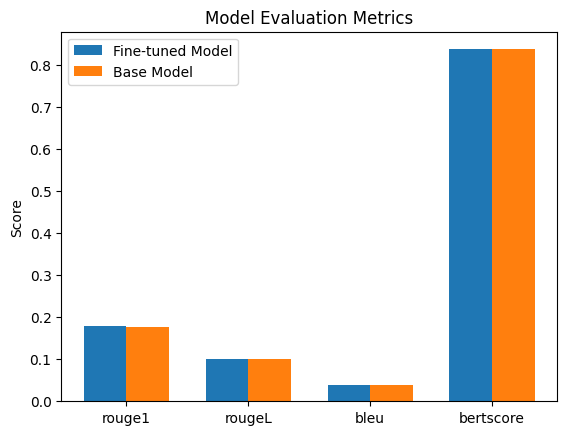

In [23]:


# Convert to DataFrames
fine_df = pd.DataFrame(fine_tuned_metrics)
base_df = pd.DataFrame(base_model_metrics)

# Calculate means
fine_means = fine_df.mean()
base_means = base_df.mean()

# Plot
metrics = ["rouge1", "rougeL", "bleu", "bertscore"]

x = range(len(metrics))
width = 0.35

plt.bar(x, fine_means[metrics], width=width, label="Fine-tuned Model")
plt.bar([i + width for i in x], base_means[metrics], width=width, label="Base Model")

plt.xticks([i + width/2 for i in x], metrics)
plt.ylabel("Score")
plt.title("Model Evaluation Metrics")
plt.legend()
plt.show()


## LLM as a Judge

In [28]:
import os
import pandas as pd
import re
import time
from together import Together

client = Together(api_key=together_api_key)

samples = pd.read_csv("/kaggle/working/summaries_comparison.csv")


evaluations = []

for idx, row in samples.iterrows():
    article = row["Input Article"][:3000]
    summary = row["Fine-tuned Model Summary"]

    prompt = f"""
You are a helpful scientific writing evaluator. Assess the quality of a machine-generated summary of a scientific article based on the following:

1. **Fluency** (1-5): Is the summary readable and grammatically correct?
2. **Factuality** (1-5): Are the claims accurate and reflective of the original article?
3. **Coverage** (1-5): Does the summary include the main problem, method, and key findings?

Provide a score (1 to 5) and one-sentence justification for each.

### Article:
{article}

### Generated Summary:
{summary}

### Evaluation:
Fluency:
Factuality:
Coverage:
"""

    response = client.chat.completions.create(
        model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
    )

    evaluation = response.choices[0].message.content.strip()
    evaluations.append({
        "Input Article": article,
        "Generated Summary": summary,
        "Evaluation": evaluation
    })
    time.sleep(60)

# Save raw evaluation output
eval_df = pd.DataFrame(evaluations)
eval_df.to_csv("llm_judge_fp8_evaluations.csv", index=False)
print("✅ Saved evaluation to llm_judge_fp8_evaluations.csv")

# Optional: parse numeric scores and calculate averages
fluency_scores, factuality_scores, coverage_scores = [], [], []

for eval in eval_df["Evaluation"]:
    flu = re.search(r'Fluency.*?(\d)', eval)
    fac = re.search(r'Factuality.*?(\d)', eval)
    cov = re.search(r'Coverage.*?(\d)', eval)
    if flu and fac and cov:
        fluency_scores.append(int(flu.group(1)))
        factuality_scores.append(int(fac.group(1)))
        coverage_scores.append(int(cov.group(1)))

print(f"\n🔎 Average Fluency: {sum(fluency_scores)/len(fluency_scores):.2f}")
print(f"🔎 Average Factuality: {sum(factuality_scores)/len(factuality_scores):.2f}")
print(f"🔎 Average Coverage: {sum(coverage_scores)/len(coverage_scores):.2f}")


RateLimitError: Error code: 429 - {"message": "You have reached the rate limit specific to this model meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8. The maximum rate limit for this model is 0.6 queries and 60000 tokens per minute. This limit differs from the general rate limits published at Together AI rate limits documentation (https://docs.together.ai/docs/rate-limits). For inquiries about increasing your model-specific rate limit, please contact our sales team (https://www.together.ai/forms/contact-sales)", "type_": "model_rate_limit"}